In [9]:
# autoreload 
%load_ext autoreload
%autoreload 2
import argparse
import json
import os
import warnings
import sys

sys.path.append("../")

import pandas as pd
from sklearn.metrics import r2_score

from domains.samplers import SyntheticDataSampler
from models.MoE import MoE, MoELinear
from models.MoE import *
from models.utils import *
from models.additive_parallel_comp_model import get_additive_model_effects
warnings.filterwarnings('ignore')

def parse_arguments():
    parser = argparse.ArgumentParser(description="Train modular neural network architectures and baselines for causal effect estimation")
    parser.add_argument("--domain", type=str, default="synthetic_data", help="Domain")
    parser.add_argument("--biasing_covariate", type=str, default="feature_sum", help="Biasing covariate")
    parser.add_argument("--bias_strength", type=float, default=0, help="Bias strength")
    parser.add_argument("--scale", type=bool, default=False, help="Scale data")
    parser.add_argument("--num_modules", type=int, default=4, help="Number of modules")
    parser.add_argument("--num_feature_dimensions", type=int, default=10, help="Number of feature dimensions")
    parser.add_argument("--num_samples", type=int, default=10000, help="Number of samples")
    parser.add_argument("--module_function_type", type=str, default="quadratic", help="Module function type")
    parser.add_argument("--composition_type", type=str, default="parallel", help="Composition type")
    parser.add_argument("--resample", type=bool, default=True, help="Resample data")
    parser.add_argument("--seed", type=int, default=42, help="Seed for reproducibility")
    parser.add_argument("--fixed_structure", type=bool, default=True, help="Fixed structure flag")
    parser.add_argument("--data_dist", type=str, default="uniform", help="Data distribution")
    parser.add_argument("--heterogeneity", type=float, default=1.0, help="Heterogeneity")
    parser.add_argument("--split_type", type=str, default="ood", help="Split type")
    # hidden_dim
    parser.add_argument("--hidden_dim", type=int, default=64, help="Hidden dimension")
    # epochs
    parser.add_argument("--epochs", type=int, default=100, help="Number of epochs")
    # batch_size
    parser.add_argument("--batch_size", type=int, default=64, help="Batch size")
    # output_dim
    parser.add_argument("--output_dim", type=int, default=1, help="Output dimension")
    # covariates_shared
    parser.add_argument("--covariates_shared", type=bool, default=True, help="Covariates shared")
    # model_class
    parser.add_argument("--underlying_model_class", type=str, default="MLP", help="Model class")
    # run_env
    parser.add_argument("--run_env", type=str, default="local", help="Run environment")
    # use_subset_features
    parser.add_argument("--use_subset_features", type=bool, default=False, help="Use subset features")
    # generate trees systematically for creating OOD data
    parser.add_argument("--systematic", type=bool, default=True, help="Generate trees systematically")
    return parser.parse_args(args=[])

def setup_directories(args):
    base_dir = "/Users/ppruthi/research/compositional_models/compositional_models_cate/domains" if args.run_env == "local" else "/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains"
    main_dir = f"{base_dir}/{args.domain}"
    csv_path = f"{main_dir}/csvs/fixed_structure_{args.fixed_structure}_outcomes_{args.composition_type}_systematic_{args.systematic}"
    obs_data_path = f"{main_dir}/observational_data/fixed_structure_{args.fixed_structure}_outcomes_{args.composition_type}_systematic_{args.systematic}"
    scaler_path = f"{obs_data_path}/{args.biasing_covariate}_{args.bias_strength}/{args.split_type}/scalers"
    return main_dir, csv_path, obs_data_path, scaler_path

def simulate_and_prepare_data(args, sampler, csv_path, obs_data_path, scaler_path):
    if args.resample:
        sampler.simulate_data()
        sampler.create_observational_data(biasing_covariate=args.biasing_covariate, bias_strength=args.bias_strength)
        sampler.create_iid_ood_split(split_type=args.split_type)
        sampler.create_scalers(args.split_type, biasing_covariate=args.biasing_covariate, bias_strength=args.bias_strength)
    data = pd.read_csv(f"{csv_path}/{args.domain}_data_high_level_features.csv")
    df_sampled = pd.read_csv(f"{obs_data_path}/{args.biasing_covariate}_{args.bias_strength}/df_sampled.csv")
    if args.scale:
        data, df_sampled = scale_df(data, df_sampled, scaler_path, csv_path)
    
    
    return data, df_sampled

def load_train_test_data(csv_path, args, df_sampled):
    with open(f"{csv_path}/{args.split_type}/train_test_split_qids.json", "r") as f:
        train_test_qids = json.load(f)
    train_qids, test_qids = train_test_qids["train"], train_test_qids["test"]
    train_df = df_sampled[df_sampled["query_id"].isin(train_qids)]
    test_df = df_sampled[df_sampled["query_id"].isin(test_qids)]
    return train_df, test_df, train_qids, test_qids

def train_and_evaluate_model(model, train_df, test_df, covariates, treatment, outcome, epochs, batch_size, train_qids, test_qids):
    model, _, _ = train_model(model, train_df, covariates, treatment, outcome, epochs, batch_size)
    train_estimates = predict_model(model, train_df, covariates)
    test_estimates = predict_model(model, test_df, covariates)
    train_df.loc[:, "estimated_effect"] = train_estimates
    test_df.loc[:, "estimated_effect"] = test_estimates
    estimated_effects_train = get_estimated_effects(train_df, train_qids)
    estimated_effects_test = get_estimated_effects(test_df, test_qids)
    return estimated_effects_train, estimated_effects_test

def calculate_metrics(gt_effects, estimated_effects):
    pehe_score = pehe(gt_effects, estimated_effects)
    r2_score_val = r2_score(gt_effects, estimated_effects)
    return pehe_score, r2_score_val

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
args = parse_arguments()
main_dir, csv_path, obs_data_path, scaler_path = setup_directories(args)

sampler = SyntheticDataSampler(args.num_modules, args.num_feature_dimensions, args.composition_type, 
                                args.fixed_structure, args.num_modules, args.num_samples, args.seed, 
                                args.data_dist, args.module_function_type, resample=args.resample, 
                                heterogeneity=args.heterogeneity, covariates_shared=args.covariates_shared, 
                                use_subset_features=args.use_subset_features, systematic=args.systematic, 
                                run_env=args.run_env)

data, df_sampled = simulate_and_prepare_data(args, sampler, csv_path, obs_data_path, scaler_path)
train_df, test_df, train_qids, test_qids = load_train_test_data(csv_path, args, df_sampled)

# fix this code to handle shared covariates
# if args.covariates_shared:
#     # find non-zero module number
#     num_covariates = [x for x in train_df.columns if "num" in x]
#     for covariate in num_covariates:
#         if train_df[covariate].sum() != 0:
#             module_num = int(covariate.split("_")[-1])
#             covariates = [x for x in train_df.columns if f"module_{module_num}_feature" in x]
#             break
# else:
covariates = [x for x in train_df.columns if "feature" in x]


# covariates = [x for x in train_df.columns if "module_1_feature" in x] if args.covariates_shared else [x for x in train_df.columns if "feature" in x]
if args.systematic:
    covariates += [x for x in train_df.columns if "num" in x]

treatment, outcome = "treatment_id", "query_output"

gt_effects_test = get_ground_truth_effects(data, test_qids)
gt_effects_train = get_ground_truth_effects(data, train_qids)

input_dim = len(covariates)
models = {
    "Baseline": BaselineModel if args.underlying_model_class == "MLP" else BaselineLinearModel,
    "MoE": MoE if args.underlying_model_class == "MLP" else MoELinear
}
results = {}
for model_name, model_class in models.items():
    print(f"Training {model_name} Model")
    if model_name == "Baseline":
        model = model_class(input_dim + 1, (input_dim + 1) * 2, args.output_dim)
    else:
        model = model_class(input_dim + 1, (input_dim + 1) * 2, args.output_dim, args.num_modules)
    
    estimated_effects_train, estimated_effects_test = train_and_evaluate_model(
        model, train_df, test_df, covariates, treatment, outcome, args.epochs, args.batch_size, train_qids, test_qids
    )
    gt_effects_train_values, gt_effects_test_values = np.array(list(gt_effects_train.values())), np.array(list(gt_effects_test.values()))
    estimated_effects_train_values, estimated_effects_test_values = np.array(list(estimated_effects_train.values())), np.array(list(estimated_effects_test.values()))
    results[f"{model_name}_train"] = calculate_metrics(gt_effects_train_values, estimated_effects_train_values)
    results[f"{model_name}_test"] = calculate_metrics(gt_effects_test_values, estimated_effects_test_values)

print("Training Additive Model")
additive_combined_train_df, additive_combined_test_df, module_csvs = get_additive_model_effects(
    csv_path, obs_data_path, train_qids, test_qids, hidden_dim=args.hidden_dim, epochs=args.epochs, 
    batch_size=args.batch_size, output_dim=args.output_dim, underlying_model_class=args.underlying_model_class, scale=args.scale, scaler_path=scaler_path
)

results["Additive_train"] = calculate_metrics(additive_combined_train_df["ground_truth_effect"], additive_combined_train_df["estimated_effect"])
results["Additive_test"] = calculate_metrics(additive_combined_test_df["ground_truth_effect"], additive_combined_test_df["estimated_effect"]) 

num_modules:  10
Reinitializing path 0
Reinitializing path 1
Reinitializing csv folder
Resampling data
Generating input trees
Generating input trees
Generating trees for group size: 2
Number of combinations: 45
Group size: 2, Number of trees: 990
Generating trees for group size: 3
Number of combinations: 120
Group size: 2, Number of trees: 990
Group size: 3, Number of trees: 960
Generating trees for group size: 4
Number of combinations: 210
Group size: 2, Number of trees: 990
Group size: 3, Number of trees: 960
Group size: 4, Number of trees: 840
Generating trees for group size: 5
Number of combinations: 252
Group size: 2, Number of trees: 990
Group size: 3, Number of trees: 960
Group size: 4, Number of trees: 840
Group size: 5, Number of trees: 756
Generating trees for group size: 6
Number of combinations: 210
Group size: 2, Number of trees: 990
Group size: 3, Number of trees: 960
Group size: 4, Number of trees: 840
Group size: 5, Number of trees: 756
Group size: 6, Number of trees: 8

In [8]:
for key, value in results.items():
    print(f"{key}: {value}")
    

Baseline_train: (0.035068164882800915, 0.9927851248853691)
Baseline_test: (0.26406226667305505, -1.8060285984046955)
MoE_train: (0.019392950295602895, 0.9977935682049688)
MoE_test: (0.1280038268706722, 0.3406358863696055)
Additive_train: (0.0643820844696444, 0.9756817227507798)
Additive_test: (0.08201718359166399, 0.7292994719755939)


In [5]:
data

,query_id,treatment_id,tree_depth,num_module_1,num_module_2,num_module_3,module_1_feature_feature_0,module_1_feature_feature_1,module_2_feature_feature_0,module_2_feature_feature_1,module_3_feature_feature_0,module_3_feature_feature_1,module_1_output,module_2_output,module_3_output,query_output
0,0,0,2,1,1,0,0.374540,0.950714,0.374540,0.950714,0.000000,0.000000,1.172481,1.192775,0.000000,2.365255
1,1,0,2,1,1,0,0.417022,0.720324,0.417022,0.720324,0.000000,0.000000,0.892102,1.129080,0.000000,2.021183
2,2,0,2,1,1,0,0.435995,0.025926,0.435995,0.025926,0.000000,0.000000,0.413815,0.852084,0.000000,1.265898
3,3,0,2,1,1,0,0.550798,0.708148,0.550798,0.708148,0.000000,0.000000,0.911319,1.330571,0.000000,2.241890
4,4,0,2,1,1,0,0.967030,0.547232,0.967030,0.547232,0.000000,0.000000,0.877776,2.088761,0.000000,2.966537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3993,1994,1,3,1,1,1,0.362305,0.985309,0.362305,0.985309,0.362305,0.985309,1.582501,1.932012,0.962793,4.477307
3994,1995,1,3,1,1,1,0.197763,0.315026,0.197763,0.315026,0.197763,0.315026,0.857034,0.952120,0.793774,2.602927
3995,1996,1,3,1,1,1,0.445604,0.908356,0.445604,0.908356,0.445604,0.908356,1.588981,1.834823,1.019559,4.443362
3996,1997,1,3,1,1,1,0.956562,0.663103,0.956562,0.663103,0.956562,0.663103,2.121726,1.759359,1.472956,5.354041


In [6]:
X = test_df[covariates].values
X_1 = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
X_1 = torch.tensor(X_1, dtype=torch.float32)
# predicted_effect_1 = model(X_1).cpu().numpy()






In [7]:
train_df[covariates]

,module_1_feature_feature_0,module_1_feature_feature_1,num_module_1,num_module_2,num_module_3
0,0.374540,0.950714,1,1,0
1,0.417022,0.720324,1,1,0
2,0.435995,0.025926,1,1,0
3,0.550798,0.708148,1,1,0
4,0.967030,0.547232,1,1,0
...,...,...,...,...,...
994,0.000000,0.000000,0,1,1
995,0.000000,0.000000,0,1,1
996,0.000000,0.000000,0,1,1
997,0.000000,0.000000,0,1,1


In [6]:
test_df[covariates]

,module_1_feature_feature_0,module_1_feature_feature_1,num_module_1,num_module_2,num_module_3
999,-1.486861,-0.756164,1,1,1
1000,-0.787960,-0.878021,1,1,1
1001,1.413230,-0.869135,1,1,1
1002,-0.752976,0.895476,1,1,1
1003,-0.145807,0.955395,1,1,1
...,...,...,...,...,...
1994,-0.529272,1.280655,1,1,1
1995,-1.396463,-1.002109,1,1,1
1996,0.888037,-1.555292,1,1,1
1997,0.000344,-0.202677,1,1,1


# Results Analysis

In [22]:
# Save results and CSVs
results_path = f"{main_dir}/results/results_{args.data_dist}_{args.module_function_type}_{args.composition_type}_covariates_shared_{args.covariates_shared}_underlying_model_{args.underlying_model_class}_use_subset_features_{args.use_subset_features}_systematic_{args.systematic}"
os.makedirs(results_path, exist_ok=True)
with open(f"{results_path}/results_{args.num_modules}_{args.num_feature_dimensions}_scale_{args.scale}.json", "w") as f:
    json.dump(results, f)



results_csv_folder = f"{main_dir}/results/csvs"
os.makedirs(results_csv_folder, exist_ok=True)
# Save combined_df_test and module_csvs here
additive_combined_test_df.to_csv(f"{results_csv_folder}/additive_combined_test_df.csv", index=False)
for module_file, module_csv in module_csvs.items():
    module_csv.to_csv(f"{results_csv_folder}/{module_file}.csv", index=False)

print(f"Results saved at {results_path}")
print(f"CSVs saved at {results_csv_folder}")
print("Done!")

Results saved at /Users/ppruthi/research/compositional_models/compositional_models_cate/domains/synthetic_data/results/results_uniform_quadratic_parallel_covariates_shared_False_underlying_model_MLP_use_subset_features_False_systematic_False
CSVs saved at /Users/ppruthi/research/compositional_models/compositional_models_cate/domains/synthetic_data/results/csvs
Done!


In [23]:
def scatter_plot(df, x, y, title, xlabel, ylabel, save_path=None):
    plt.scatter(df[x], df[y])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [24]:
combined_df_test

,ground_truth_effect,estimated_effect
0,-0.293698,-0.311285
1,-0.641127,-0.642452
2,-0.612727,-0.604818
3,0.239012,0.246677
4,-0.717167,-0.693429
...,...,...
162,-0.719175,-0.764137
163,0.595639,0.640840
164,1.285423,1.451030
165,-0.269334,-0.208952


In [16]:
## Confirming risk decomposition of the additive parallel composition model. 
results_csv_folder = f"{main_dir}/results/csvs"
# hl_filepath = f"{results_csv_folder}/combined_df_{args.data_dist}_{args.module_function_type}_{args.composition_type}_covariates_shared_{args.covariates_shared}_underlying_model_{args.underlying_model_class}_use_subset_features_{args.use_subset_features}_systematic_{args.systematic}.csv"
hl_filepath = f"{results_csv_folder}/additive_combined_test_df.csv"
combined_df_test = pd.read_csv(hl_filepath)
# drop unnamed columns

pehe_baseline_test = pehe(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_baseline"])
pehe_additive_test = pehe(combined_df_test["ground_truth_effect_additive"], combined_df_test["estimated_effect_additive"])
pehe_moe_test = pehe(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_moe"])

print(f"PEHE Baseline: {pehe_baseline_test}")   
print(f"PEHE Additive: {pehe_additive_test}")
print(f"PEHE MoE: {pehe_moe_test}")

# R2 score
r2_baseline_test = r2_score(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_baseline"])
r2_additive_test = r2_score(combined_df_test["ground_truth_effect_additive"], combined_df_test["estimated_effect_additive"])
r2_moe_test = r2_score(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_moe"])

print(f"R2 Baseline: {r2_baseline_test}")
print(f"R2 Additive: {r2_additive_test}")
print(f"R2 MoE: {r2_moe_test}")

# scatter plot
scatter_plot(combined_df_test, "ground_truth_effect_baseline", "estimated_effect_baseline", "Baseline", "Ground Truth Effect", "Estimated Effect", save_path=None)
scatter_plot(combined_df_test, "ground_truth_effect_additive", "estimated_effect_additive", "Additive", "Ground Truth Effect", "Estimated Effect", save_path=None)
scatter_plot(combined_df_test, "ground_truth_effect_baseline", "estimated_effect_moe", "MoE", "Ground Truth Effect", "Estimated Effect", save_path=None)


KeyError: 'ground_truth_effect_baseline'

# Data Analysis

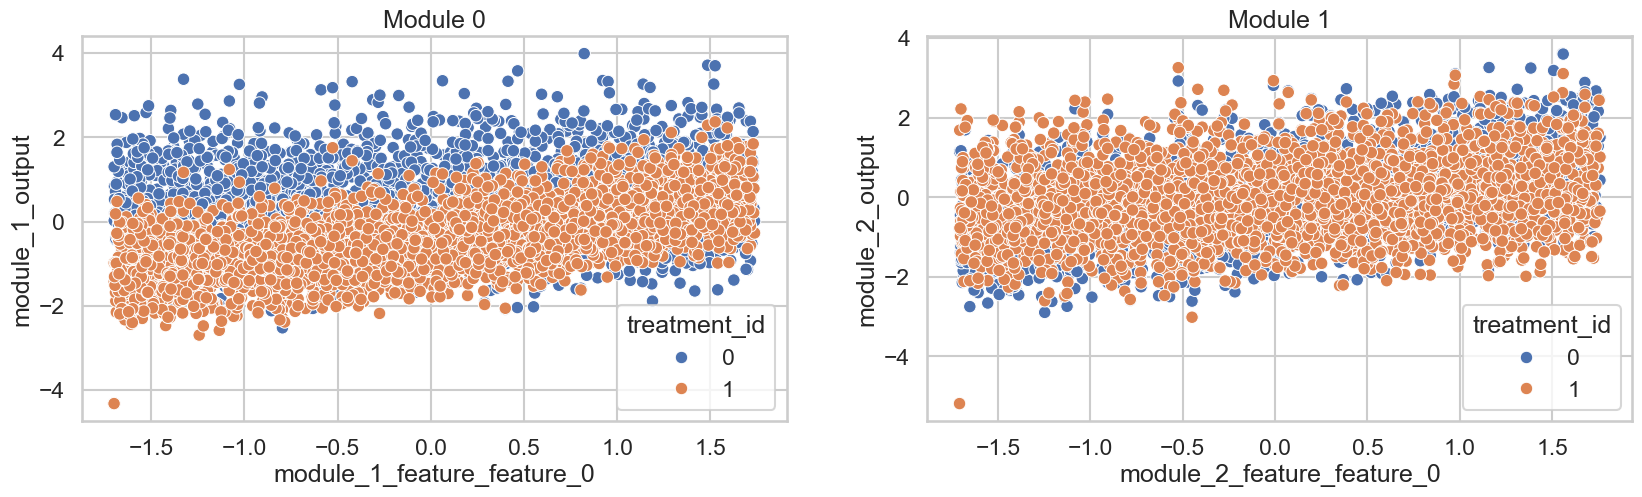

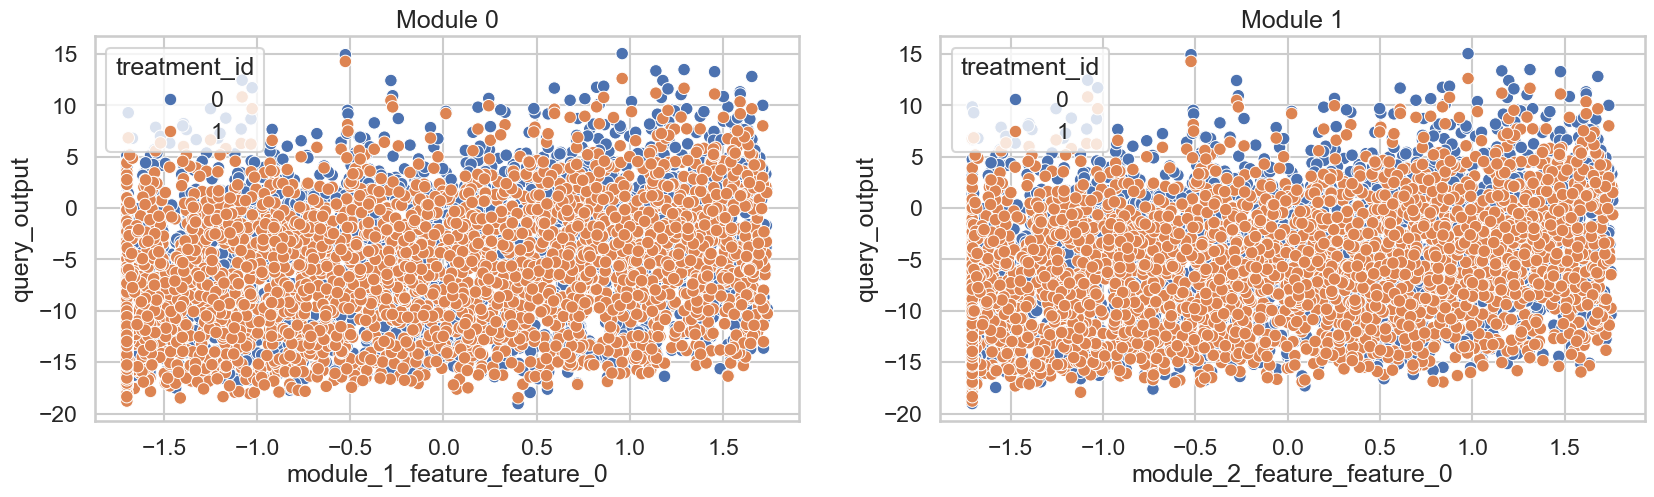

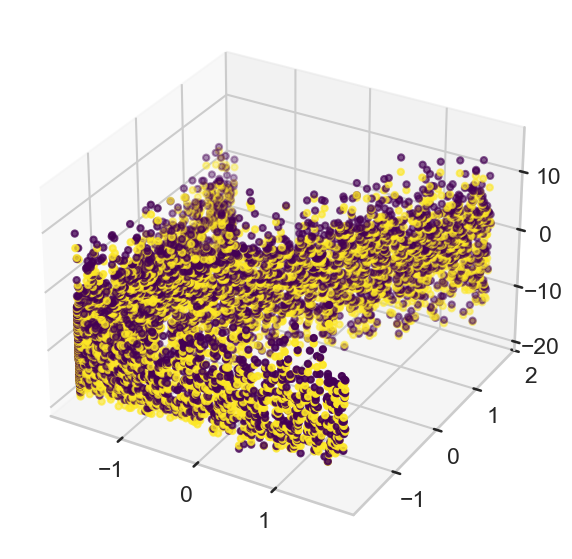

In [33]:
# Hypotheses to test
# 1. Each component output is a quadratic function of the input features.
# 2. Plot final output vs input features.

# Hypothesis 1
# plot 1
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("talk")
max_modules = 2
fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
for i in range(max_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"module_{i+1}_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
for i in range(max_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"query_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

# Have a 3D plot for two features and one output
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["module_1_feature_feature_0"], data["module_2_feature_feature_0"], data["query_output"], c=data["treatment_id"], cmap='viridis')



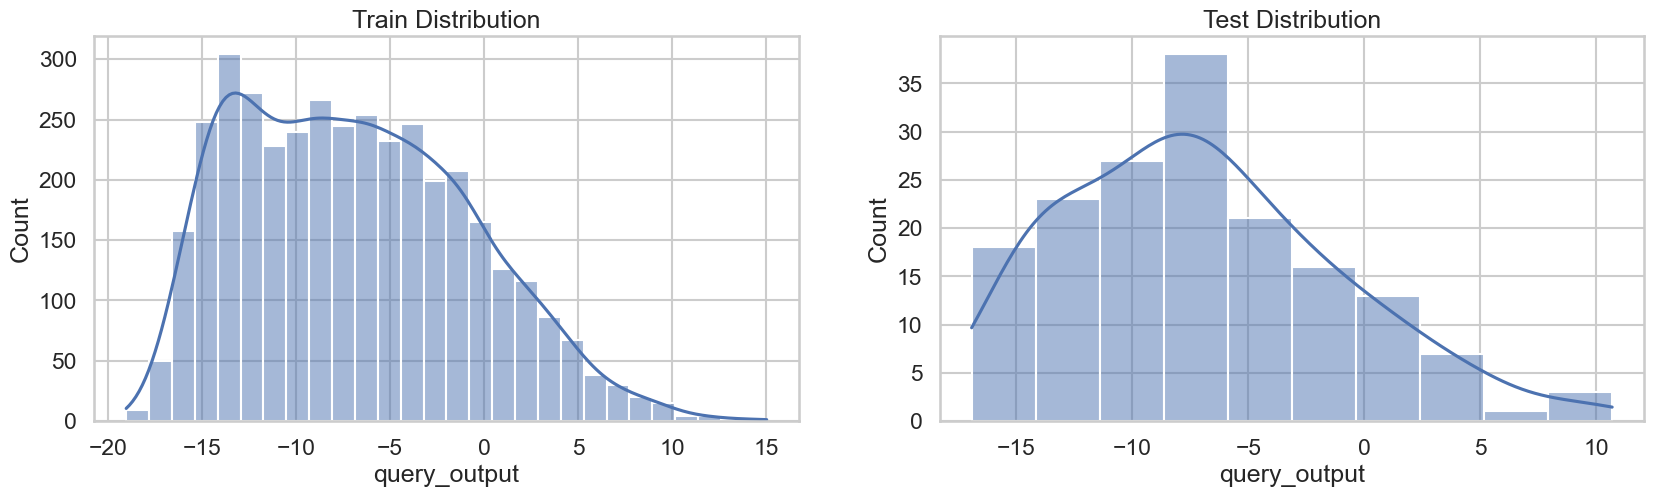

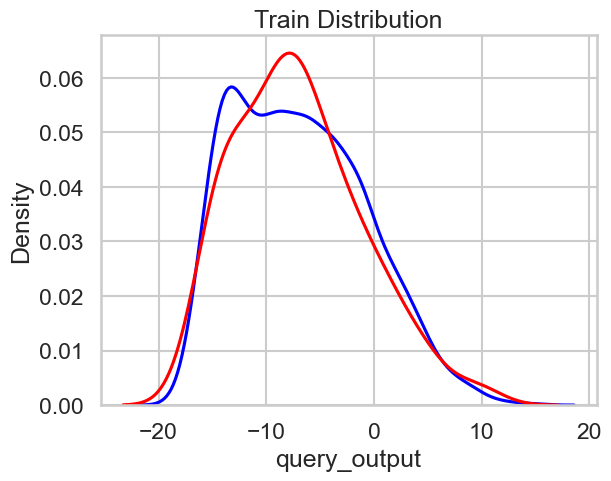

In [34]:
# plot distribution of the output for train and test df in the same plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(train_df["query_output"], ax=ax[0], kde=True)
ax[0].set_title("Train Distribution")
sns.histplot(test_df["query_output"], ax=ax[1], kde=True)
ax[1].set_title("Test Distribution")
plt.show()

# plot distribution of the output for train and test df in the same plot
# scale the distribution by dividing by the number of samples
sns.kdeplot(train_df["query_output"], label="Train", color="blue")
sns.kdeplot(test_df["query_output"], label="Test", color="red")
plt.title("Train Distribution")
plt.show()





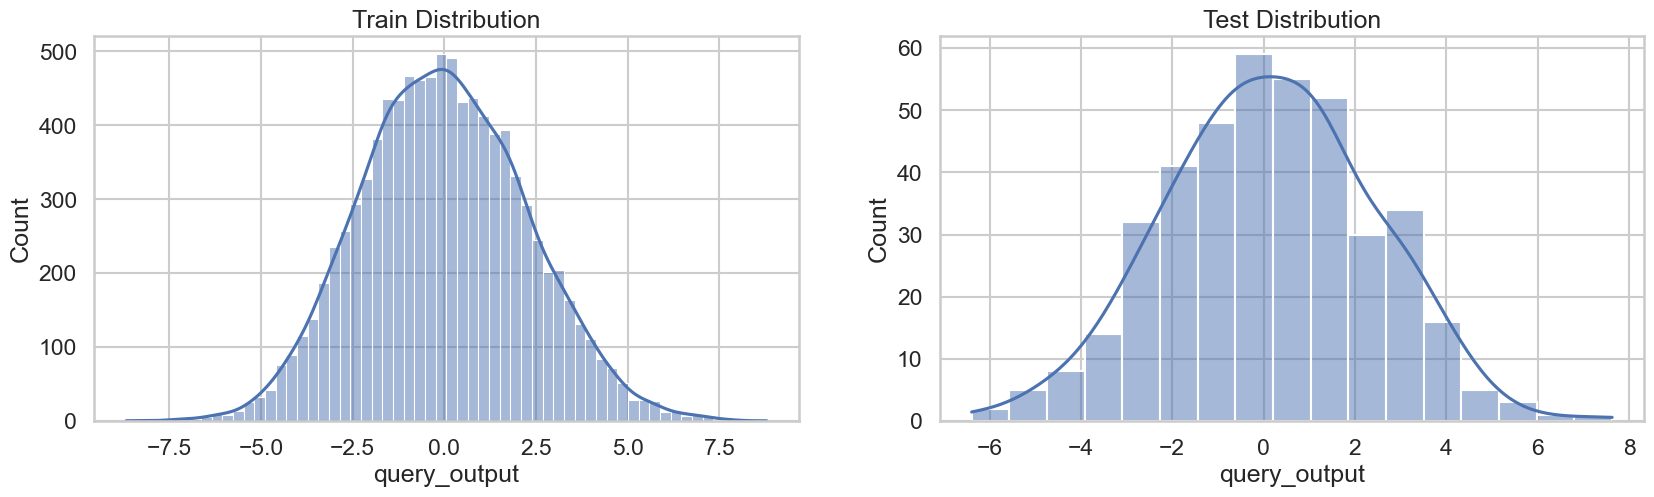

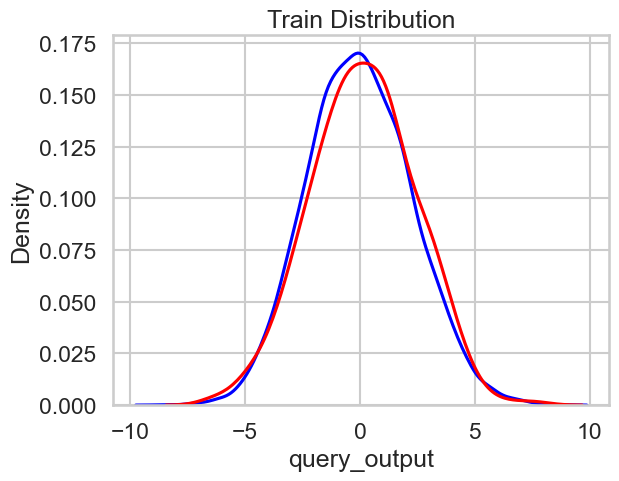

In [22]:
# plot distribution of the output for train and test df in the same plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(train_df["query_output"], ax=ax[0], kde=True)
ax[0].set_title("Train Distribution")
sns.histplot(test_df["query_output"], ax=ax[1], kde=True)
ax[1].set_title("Test Distribution")
plt.show()

# plot distribution of the output for train and test df in the same plot
# scale the distribution by dividing by the number of samples
sns.kdeplot(train_df["query_output"], label="Train", color="blue")
sns.kdeplot(test_df["query_output"], label="Test", color="red")
plt.title("Train Distribution")
plt.show()





# Data baseline model 

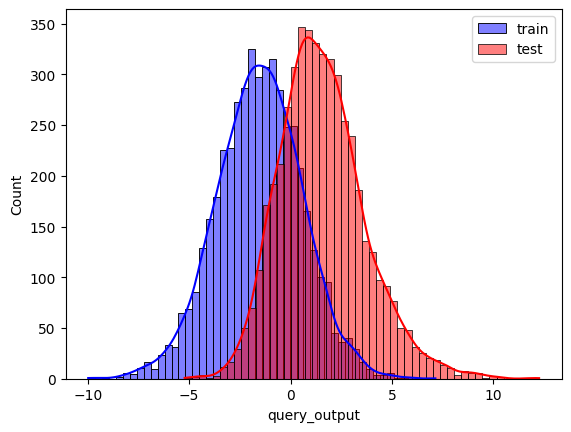

In [5]:
# plot feature distribution of module_1_feature_feature_0
import seaborn as sns
# sns.histplot(train_df[high_level_output], bins=50, color="blue", label="train", kde=True)
# sns.histplot(test_df[high_level_output], bins=50, color="red", label="test", kde=True)

# have two histograms based on treatment
sns.histplot(train_df[train_df["treatment_id"]==0]["query_output"], bins=50, color="blue", label="train", kde=True)
sns.histplot(train_df[train_df["treatment_id"]==1]["query_output"], bins=50, color="red", label="test", kde=True)

plt.legend()




# sns.histplot(data[high_level_output], bins=50, color="green")

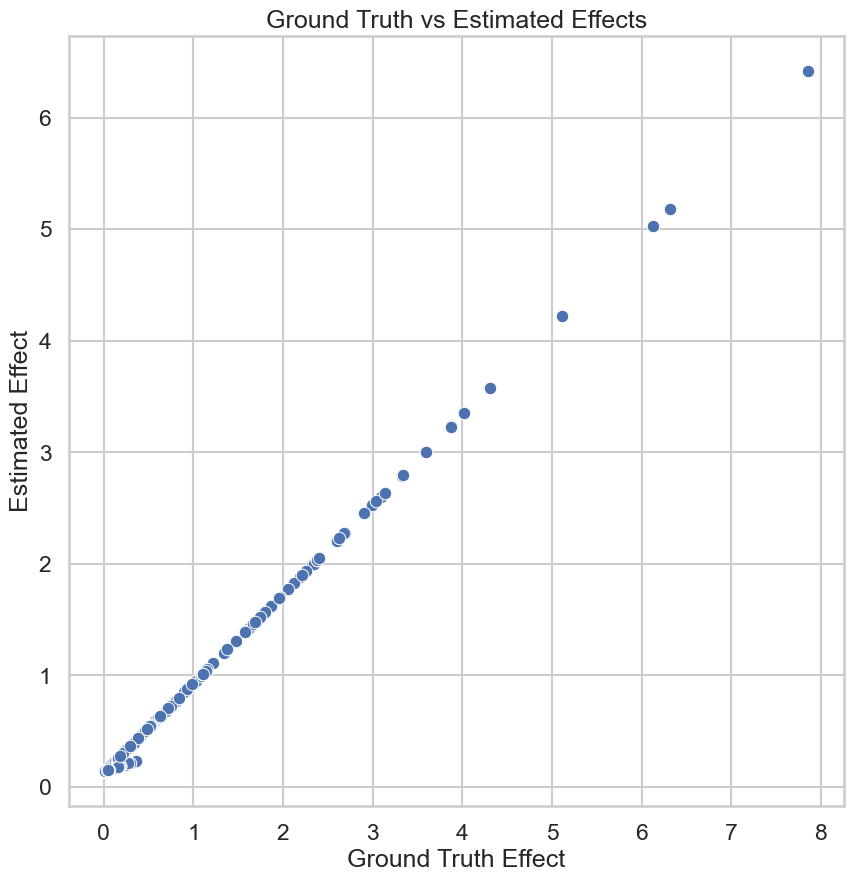

In [55]:
# scatter plot of ground truth vs estimated effects
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x="ground_truth_effect", y="estimated_effect", data=baseline_combined_df, ax=ax)
ax.set_xlabel("Ground Truth Effect")
ax.set_ylabel("Estimated Effect")
ax.set_title("Ground Truth vs Estimated Effects")

plt.show()

